# <center>EE6770 Fall 2024 Homework 5: Cats and Dogs Classifier</center>

1. __Write comments__ in the code to explain your thoughts.
2. __Important: Execute the codes and show the results__. 
3. __Do your own work.__ 

### Submission:
 * __Submit this notebook file and the pdf version__ - remember to add your name in the filename.
 * Deadline: 11:59 pm, 10/28 (Monday)

## Assignment Objectives:

### In this assignment, you will develop a CNN model for the cat-and-dog classifer. 
#### You will create `at least two models`, applying the various techniques we discussed for improving the performance. 

1. Deeper Conv layers and/or FC layers
2. Image augmentation
3. Transfer learning
4. Regularization: L1/L2, Batch Normalization, Dropout, Max Norm
5. Increasing image size
6. Increasing size of the train/validation/test dataset

* You will compare the performance of your models with the baseline VGG-5 model that we discussed in class.
* <font color=red>Image size is limited to 128-by-128 or smaller </font>
* <font color=red>Performance requirement: the accuracy on the test data needs to be better than 87.5% for at least one of your models </font>

### Cats & Dogs Dataset

* #### You are given a zip file, `train.zip`, that contains 25,000 labelled images of cats and dogs (12,500 each) 
* #### You will select a subset of $N$ image files from the dataset and store them in the following sub-directory structure, where $N$ can be anywhere between 10,000 to 25,000.
* #### The train-validation-test data split is 60%-15%-25%.
<img src="./images/train_test_dir.png" alt="Drawing" style="width: 250px;"/> 

### Load tool modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

print(tf.config.list_physical_devices())

2024-10-28 11:16:43.189394: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 11:16:43.301756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:16:43.326821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:16:43.333645: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:16:43.445783: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1730128606.523224    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128606.762438    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128606.762492    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### Load CNN models

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

### Load the image processing tools 

In [3]:
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import image_dataset_from_directory

### Load and Process the dataset
__Create the subdirectory structures per the requirement.__

In [4]:
import os
import shutil

#--------------------------------------#
# Select the number of files to train  #
N = 25000                              #
#--------------------------------------#

source_dir = "./train"
train_dir = "./cats_dogs"

os.makedirs(train_dir, exist_ok=True)

def organize_images(name, start, stop):
    for pet in ("cat", "dog"):
        dir = train_dir + "/" + name + "/" + pet
        os.makedirs(dir, exist_ok=True)

        images = [f"{pet}.{i}.jpg" for i in range(start, stop)]
        for file in images:
            shutil.copy(src=source_dir + '/' + file, dst=dir + '/ '+ file)


N_split = int(25000 / 2)
train_perc = int(N_split * 0.6)
val_percent = train_perc + int(N_split * 0.15)
test_percent = val_percent + int(N_split * 0.25)

organize_images("train", start=0, stop=train_perc)
organize_images("validation", start=train_perc, stop=val_percent)
organize_images("test", start=val_percent, stop=test_percent)

### Display 2 input images: one for dog, and one for cat 

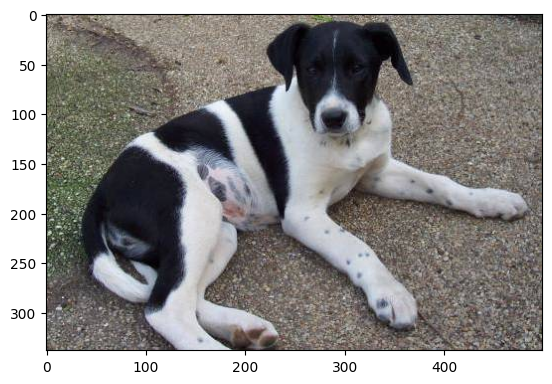

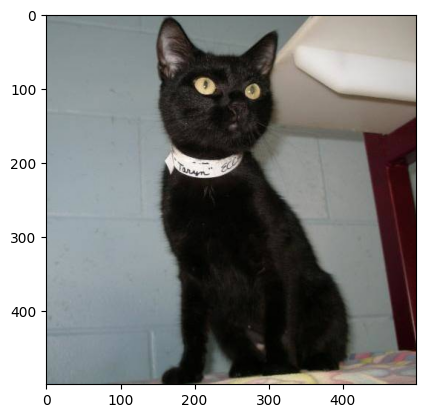

In [5]:
import matplotlib.pyplot as plt
import random


dog_dir = os.listdir(train_dir+'/test'+'/dog')
cat_dir = os.listdir(train_dir+'/test'+'/cat')
dog_sample = random.choice(dog_dir)
cat_sample = random.choice(cat_dir)


dog_img = load_img(os.path.join(train_dir+'/test'+'/dog', dog_sample))
cat_img = load_img(os.path.join(train_dir+'/test'+'/cat', cat_sample))

plt.imshow(dog_img)
plt.show()

plt.imshow(cat_img)
plt.show()

# Baseline CNN Model: VGG-5

In [6]:
# create data generator

# ----------- Target Picture Size ------------ #
target_pic_size = (64, 64)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #


train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)


    
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=target_pic_shape))
model.add(MaxPooling2D((2, 2)))

# Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

# FC Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.summary()





Found 15000 files belonging to 2 classes.


I0000 00:00:1730128623.915966    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128623.916072    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128623.916097    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128624.143644    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730128624.143758    1056 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-28

Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


/home/rbrin/miniconda3/envs/tf-gpu2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(train_data, epochs=10, batch_size=64, validation_data=val_data, verbose=1)


Epoch 1/10


I0000 00:00:1730128626.613970   12987 service.cc:146] XLA service 0x7fb53c0168e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730128626.614003   12987 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-10-28 11:17:06.671619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 11:17:06.833960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 18/235 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5101 - loss: 34.9637

I0000 00:00:1730128629.020013   12987 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5486 - loss: 6.1784 - val_accuracy: 0.6325 - val_loss: 0.6350
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6495 - loss: 0.6250 - val_accuracy: 0.6440 - val_loss: 0.6584
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6955 - loss: 0.5733 - val_accuracy: 0.7315 - val_loss: 0.5307
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7503 - loss: 0.5125 - val_accuracy: 0.7125 - val_loss: 0.5552
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7766 - loss: 0.4743 - val_accuracy: 0.7661 - val_loss: 0.4856
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8020 - loss: 0.4260 - val_accuracy: 0.7781 - val_loss: 0.4846
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8191 - loss: 0.4025 - val_accuracy: 0.7856 - val_loss: 0.4819
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8483 - loss: 0.3451 - val_accuracy: 0.782

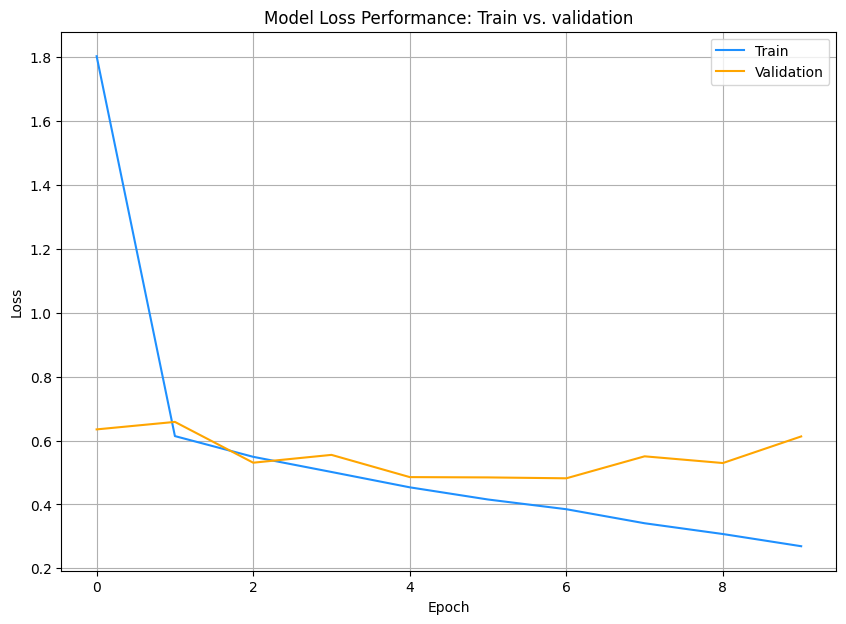

In [8]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

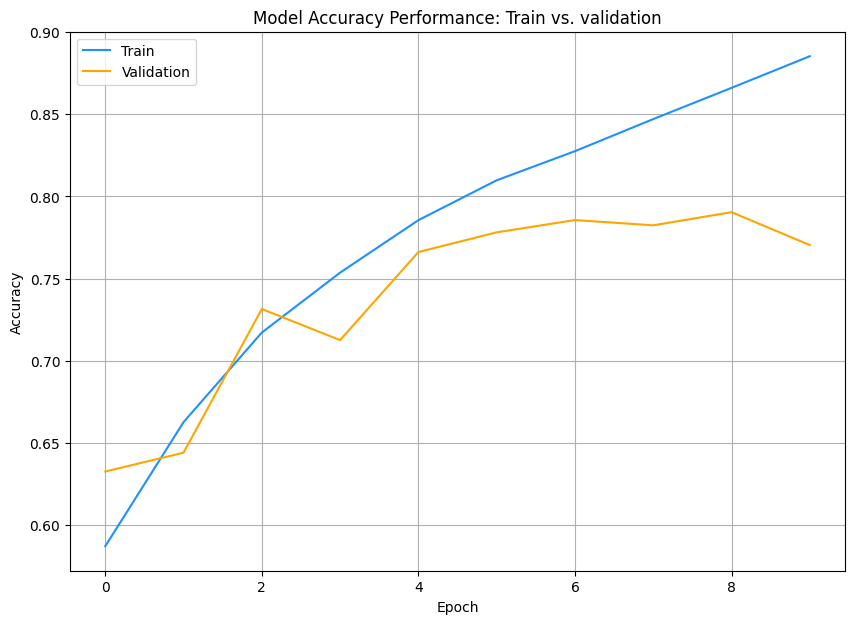

98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7796 - loss: 0.5987
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [9]:
accu = history.history['accuracy']  # Loss data for Training 
accu_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Accuracy Performance: Train vs. validation')
plt.plot(accu, color='DodgerBlue', label='Train')
plt.plot(accu_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

loss, accuracy = model.evaluate(test_data, verbose=1)

y_pred = model.predict(test_data)

In [10]:
print("Accuracy = ", accuracy *100, "%")
print("Loss = ", loss, "%")

Accuracy =  76.46399736404419 %
Loss =  0.6199353337287903 %


# <font color=blue>Build CNN Model One</font>

## <font color=green>Define the CNN model</font> 

__Use CONV, POOL and FC layers to construct your CNN model. You can also load pre-trained model, if transfer learning is used. You will train and test the model after this step.__

In [28]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)



cnn1 = Sequential()


# Input layer
cnn1.add(keras.Input(shape=target_pic_shape))

# Layer 1
cnn1.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 2
cnn1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 3
cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 4
cnn1.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(MaxPooling2D((2, 2)))

# Layer 5
cnn1.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer='l2'))
cnn1.add(MaxPooling2D((2, 2)))

cnn1.add(Flatten())
cnn1.add(Dropout(rate=0.25))

# FC Layers
cnn1.add(Dense(128, activation=keras.activations.gelu))
cnn1.add(Dense(128, activation=keras.activations.gelu))
cnn1.add(Dense(1, activation=keras.activations.sigmoid))



Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


### Print the model summary that shows the output shape and # of parameters for each layer.

In [29]:
cnn1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,847,489 (7.05 MB)

 Trainable params: 1,847,489 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

### <font color=red>Question: What are the total number of parameters for the model?</font>

<font color = blue>**Answer:** This model has 1,844,641 parameters and takes up 7.04 MB</font>

## <font color=green>Train the CNN Model</font>

__Note: Display the history when running model.fit( )__

In [30]:
cnn1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn1.fit(train_data, epochs=20, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.5181 - loss: 5.9819 - val_accuracy: 0.5763 - val_loss: 2.4099
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5934 - loss: 2.1706 - val_accuracy: 0.7003 - val_loss: 1.5884
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6715 - loss: 1.4946 - val_accuracy: 0.7197 - val_loss: 1.1957
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7433 - loss: 1.1135 - val_accuracy: 0.7544 - val_loss: 0.9589
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7683 - loss: 0.9085 - val_accuracy: 0.7755 - val_loss: 0.8121
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7940 - loss: 0.7690 - val_accuracy: 0.7456 - val_loss: 0.8056
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8075 - loss: 0.6783 - val_accuracy: 0.7853 - val_loss: 0.6881
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8072 - loss: 0.6462 - val_acc

### <font color=red>Question: What is the estimated total model training time?</font>

<font color=blue>**Answer:** With the CPU/GPU combination I have it takes about 4 minutes to run</font>

### Compare Loss and Accuracy Performance for train and validation data

#### Plot the loss data, for both train and validation data

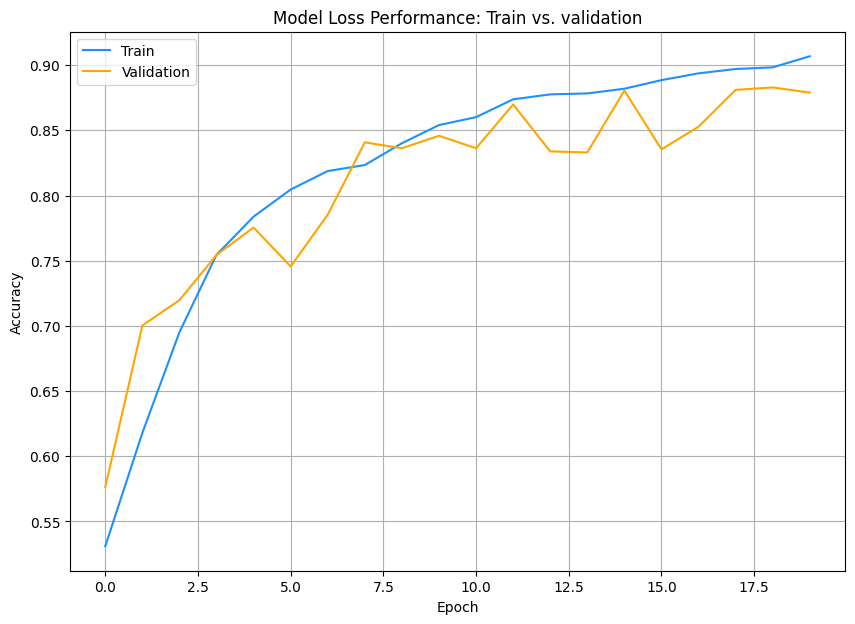

In [31]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

#### Plot the accuracy data, for both train and validation data

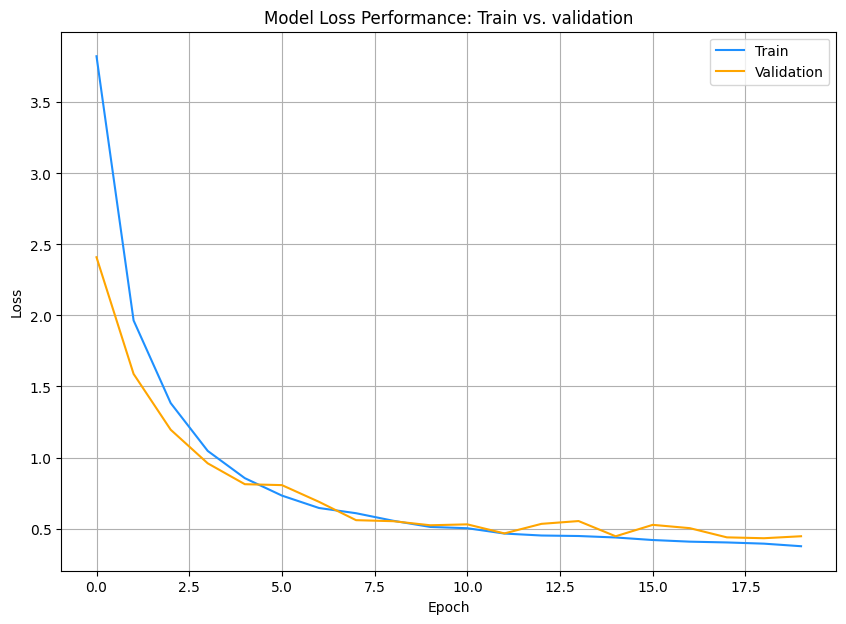

In [32]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

## <font color=green>Test the CNN Model</font>
__Note: Display the history when running model.evaluate( )__

### <font color=red>Question: What is the estimated inference (testing) time on test dataset?</font>

<font color = blue>**Answer:** It took 14 seconds to run the inference</font>

### Print the final loss and accuracy of the test data

In [33]:
loss, accuracy = cnn1.evaluate(test_data, verbose=1)

y_pred = cnn1.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8704 - loss: 0.4730
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy:  87.57 %
Loss:  0.46


### Save the CNN model parameters

In [34]:
cnn1.save('./cnn1.keras')

# <font color=blue>Build CNN Model Two</font>

__For your second and subsequent models, follow the same set of instructions provided for Model One__

In [35]:
# ----------- Target Picture Size ------------ #
target_pic_size = (128, 128)                     #
target_pic_shape = target_pic_size + (3,)      #
# -------------------------------------------- #

train_data = image_dataset_from_directory(train_dir + '/train',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)

val_data = image_dataset_from_directory(train_dir + '/validation',
           color_mode='rgb', batch_size=64, image_size=target_pic_size)

test_data = image_dataset_from_directory(train_dir + '/test',
            color_mode='rgb', batch_size=64, image_size=target_pic_size)



cnn2 = Sequential()

cnn2.add(keras.Input(shape=target_pic_shape))

cnn2.add(Conv2D(16, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(32, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(64, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(128, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Conv2D(256, (3,3), activation= 'relu'))
cnn2.add(MaxPooling2D((2,2)))

cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dense(1, activation='sigmoid'))

Found 15000 files belonging to 2 classes.
Found 3750 files belonging to 2 classes.
Found 6250 files belonging to 2 classes.


In [36]:
cnn2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,937 (2.00 MB)

 Trainable params: 523,937 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn2.fit(train_data, epochs=20, batch_size=64, validation_data=val_data, verbose=1)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.5648 - loss: 2.2576 - val_accuracy: 0.6253 - val_loss: 0.6676
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7011 - loss: 0.5731 - val_accuracy: 0.7035 - val_loss: 0.5782
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7674 - loss: 0.4849 - val_accuracy: 0.7696 - val_loss: 0.5096
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7928 - loss: 0.4408 - val_accuracy: 0.8069 - val_loss: 0.4135
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8353 - loss: 0.3714 - val_accuracy: 0.8088 - val_loss: 0.4292
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8532 - loss: 0.3311 - val_accuracy: 0.8237 - val_loss: 0.3977
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8803 - loss: 0.2802 - val_accuracy: 0.8336 - val_loss: 0.4099
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9052 - loss: 0.2305 - val_acc

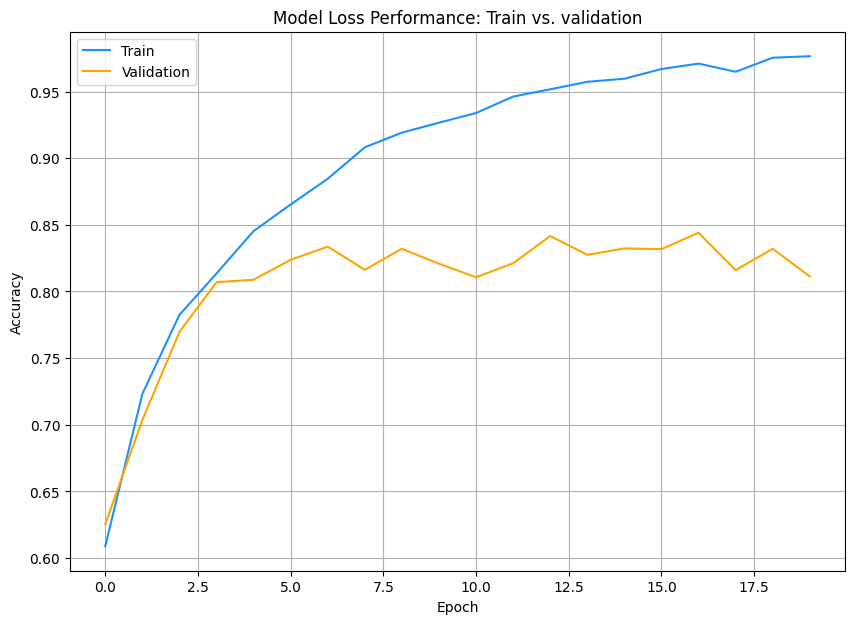

In [38]:
J = history.history['accuracy']  # Loss data for Training 
J_val = history.history['val_accuracy']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

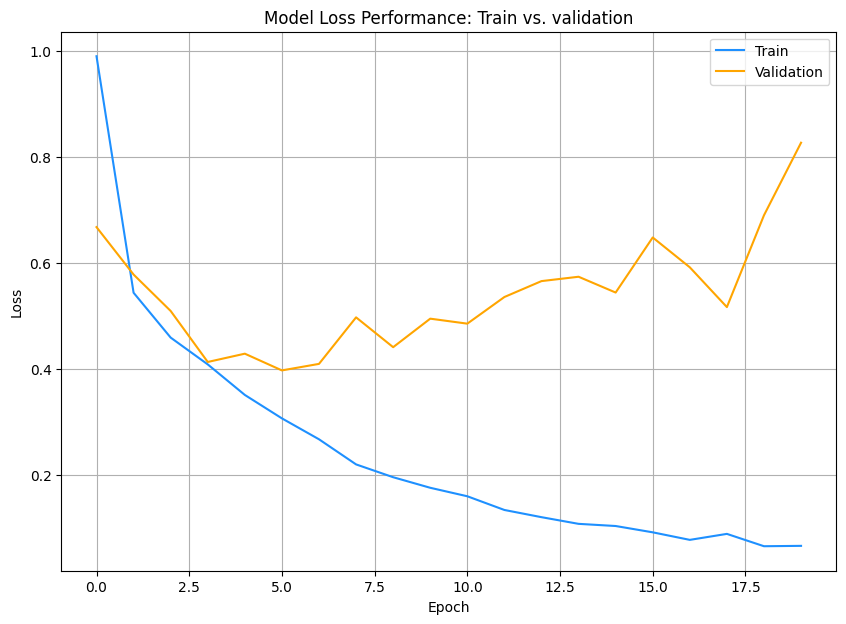

In [39]:
J = history.history['loss']  # Loss data for Training 
J_val = history.history['val_loss']

plt.figure(figsize=(10,7))

plt.title('Model Loss Performance: Train vs. validation')
plt.plot(J, color='DodgerBlue', label='Train')
plt.plot(J_val, color='orange', label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()
plt.grid()
plt.show()

In [40]:
loss, accuracy = cnn2.evaluate(test_data, verbose=1)

y_pred = cnn2.predict(test_data)

print("Accuracy: ", round(accuracy * 100, 2), "%")
print("Loss: ", round(loss, 2))

98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8229 - loss: 0.7701
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy:  81.22 %
Loss:  0.83


In [41]:
cnn2.save('./cnn2.keras')

## <font color=green>Conclusion</font>

### You will fill out information in this table:
| Model              | Accuracy  | Number of Parameters  | Training Time  | Inference Speed  |
|------------------- |-----------|-----------------------|--------------- |------------------|
| Baseline VGG-5     |   74.04%  |       683,329         |       0:30     |         02.3     |
| CNN1               |  88.34%   |       1,847,489       |      3:15      |         0:2.4    |
| CNN2               | 80.45%    |         523,937       |       1:41     |         0:2.2    |


__Please add comments on what you tried and observed while working on the assignment.__

The first thing I realized is that CNNs of any note are computationally demanding. The first couple of architectures I put together pinned my CPU at 100% and took around 1 minute per epoch. I set out then to get Tensorflow to recognize my GPU. This created a lot of headach. After days of struggling, I realized that the core of the issue is that the version of CUDA and cuDNN I am on are newer then the Tensorflow version I originally was using had. After chaning to the latest version of Tensorflow, my GPU was automatically detected. I then ran into the issue that certain features used in the provided codes were depricated. I had to code these features out and replace them with up-to-date equivalents.

I was then able to focus on iterating my architectures in earnest. At first I tried to replicate VGG-16. This was not possible because we are limeted to using a 128x128 picture size and a 3x3 filter would decrease the matrix size too fast. So I then went on to capture the spirit of VGG-16 and started out with a small number of filters, and gradually increased the number until the final CNN layer before flattening. This did a good job but I was getting low to mid 80% on my testinging accuracy. I also tried making fewer layers, but multiple filters, but that provided no advantage. I added a second hidden layer but that only increased my success marginally. The true key was adding a dropout layer after flattening. 

The dropout layer that I added was extrememly successful and allowed for my training and validation accuracy to increase in tandom together for longer numbers of epochs. Preventing over training was one of the hardest things about creating a good CNN architecture. A lot of the architectures I created would see divergence between the training and validation accuracy fairly quickly, around the 10 epoch mark. But the dropout allowed for the delay of the divergence for longer in a lot of my testing. It appears that the dropout layer allows the neural network to generalize the features a lot more and really helps prevent over training.



## <center><font color=maroon>Remember to turn in both the notebook and the pdf version.</font></center>